In [ ]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================
# Standard libraries
import os
import random
import numpy as np
import zipfile
from pathlib import Path
import time
import gc

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

# Progress bar
from tqdm import tqdm

# OpenCV for quality metrics
import cv2

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!ls /content/drive/MyDrive/'NEU - MS CS'/3_SEM/'CS - 7150 (DeepLearning)'/midterm-proj-1/data

faceforensics_dataset.zip


In [ ]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CONFIG = {
    # Data paths
    'zip_path': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/data/faceforensics_dataset.zip',
    'extract_dir': '/content/extracted_data',
    # 'save_dir': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined',
    'save_dir': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined_weighted_bce',

    # Training
    'batch_size': 64,
    'num_workers': 2,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'checkpoint_interval': 10000,

    # Data split
    'train_ratio': 0.9,
    'test_ratio': 0.1,

    # Model architecture
    'input_channels': 3,
    'image_size': 64,
    'num_classes': 2,

    # VAE architecture
    'vae_hidden_channels': [32, 64, 128],
    'vae_out_channels': 256,
    'latent_dim': 128,

    # Loss function
    'loss_type': 'weighted_bce',

    # VAE pretraining
    'vae_pretrain_epochs': 5,
    'vae_pretrain': True,  # Set to False to skip VAE pretraining
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['extract_dir'], exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


In [ ]:
# ============================================================================
# SECTION 3: MOUNT DRIVE AND LOAD DATA
# ============================================================================
# from google.colab import drive

# Mount drive only if not already mounted
# if not os.path.exists('/content/drive/MyDrive'):
#     drive.mount('/content/drive')
# else:
#     print("Google Drive already mounted")

from google.colab import drive
drive.mount('/content/drive')

# Define tensor paths
X_path = os.path.join(CONFIG['extract_dir'], 'FaceForensics_X.pt')
y_path = os.path.join(CONFIG['extract_dir'], 'FaceForensics_y.pt')

# Extract only if tensor files don't exist
if not os.path.exists(X_path) or not os.path.exists(y_path):
    print(f"Extracting dataset from zip file...")

    # Use pathlib to handle spaces properly
    from pathlib import Path
    zip_path = Path(CONFIG['zip_path'])

    if not zip_path.exists():
        raise FileNotFoundError(f"Zip file not found at: {CONFIG['zip_path']}")

    with zipfile.ZipFile(str(zip_path), 'r') as zip_ref:
        zip_ref.extractall(CONFIG['extract_dir'])
    print("Extraction complete")
else:
    print("Dataset already extracted")

# Load tensors
print(f"Loading tensors...")
X = torch.load(X_path)
y = torch.load(y_path)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Label distribution: Real (0): {(y==0).sum()}, Fake (1): {(y==1).sum()}")

In [ ]:
# ============================================================================
# SECTION 4: SHUFFLE AND SPLIT DATA
# ============================================================================
num_samples = X.shape[0]
indices = torch.randperm(num_samples)
X = X[indices]
y = y[indices]

train_size = int(num_samples * CONFIG['train_ratio'])
test_size = num_samples - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Extract real images for VAE training
real_mask = y_train == 0
X_train_real = X_train[real_mask]
print(f"Real images for VAE training: {len(X_train_real)}")

# Clean up
del X, y, indices
gc.collect()

Train: 89640, Test: 9960
Real images for VAE training: 44775


28

In [ ]:
# ============================================================================
# SECTION 5: QUALITY METRIC FUNCTIONS
# ============================================================================

def calculate_sharpness(image_tensor):
    """Calculate sharpness using Laplacian variance"""
    img = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()

def calculate_brightness(image_tensor):
    """Calculate average brightness"""
    return image_tensor.detach().mean().item()

def calculate_contrast(image_tensor):
    """Calculate contrast using standard deviation"""
    return image_tensor.detach().std().item()

def calculate_quality_loss(original_batch, reconstructed_batch):
    """
    Calculate quality degradation between original and reconstructed images
    Returns: scalar loss (lower is better)
    """
    batch_size = original_batch.size(0)
    total_quality_loss = 0.0

    for i in range(batch_size):
        orig = original_batch[i]
        recon = reconstructed_batch[i]

        # Calculate metrics for original
        orig_sharp = calculate_sharpness(orig)
        orig_bright = calculate_brightness(orig)
        orig_contrast = calculate_contrast(orig)

        # Calculate metrics for reconstruction
        recon_sharp = calculate_sharpness(recon)
        recon_bright = calculate_brightness(recon)
        recon_contrast = calculate_contrast(recon)

        # Quality degradation (absolute differences)
        sharp_loss = abs(orig_sharp - recon_sharp) / (orig_sharp + 1e-8)
        bright_loss = abs(orig_bright - recon_bright)
        contrast_loss = abs(orig_contrast - recon_contrast)

        # Combine (weighted average)
        quality_loss = (sharp_loss + bright_loss + contrast_loss) / 3.0
        total_quality_loss += quality_loss

    return total_quality_loss / batch_size

In [ ]:
def calculate_quality_loss_per_sample(original_batch, reconstructed_batch):
       """Returns per-sample quality loss as tensor (batch_size,)"""
       batch_size = original_batch.size(0)
       quality_losses = []

       for i in range(batch_size):
           orig = original_batch[i]
           recon = reconstructed_batch[i]

           # Calculate metrics
           orig_sharp = calculate_sharpness(orig)
           orig_bright = calculate_brightness(orig)
           orig_contrast = calculate_contrast(orig)

           recon_sharp = calculate_sharpness(recon)
           recon_bright = calculate_brightness(recon)
           recon_contrast = calculate_contrast(recon)

           # Quality degradation
           sharp_loss = abs(orig_sharp - recon_sharp) / (orig_sharp + 1e-8)
           bright_loss = abs(orig_bright - recon_bright)
           contrast_loss = abs(orig_contrast - recon_contrast)

           quality_loss = (sharp_loss + bright_loss + contrast_loss) / 3.0
           quality_losses.append(quality_loss)

       return torch.tensor(quality_losses, device=original_batch.device)

In [ ]:
# ============================================================================
# SECTION 6: VAE ARCHITECTURE
# ============================================================================
class ConvEncoder(nn.Module):
    """VAE Encoder: Image → Latent Space (mu, logvar)"""
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128],
                 out_channels=256, input_height=64, input_width=64, latent_dim=128):
        super().__init__()

        output_height = input_height // 2 ** (len(hidden_channels) + 1)
        output_width = input_width // 2 ** (len(hidden_channels) + 1)

        layers = []
        layers.append(nn.Conv2d(in_channels, hidden_channels[0], kernel_size=4, stride=2, padding=1))
        layers.append(nn.ReLU(True))

        for k in range(len(hidden_channels)-1):
            layers.append(nn.Conv2d(hidden_channels[k], hidden_channels[k+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(hidden_channels[k+1]))
            layers.append(nn.ReLU(True))

        layers.append(nn.Conv2d(hidden_channels[-1], out_channels, kernel_size=4, stride=2, padding=1))
        self.net = nn.Sequential(*layers)

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(out_channels * output_height * output_width, latent_dim)
        self.fc_logvar = nn.Linear(out_channels * output_height * output_width, latent_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class ConvDecoder(nn.Module):
    """VAE Decoder: Latent Space → Reconstructed Image"""
    def __init__(self, in_channels=256, hidden_channels=[128, 64, 32],
                 out_channels=3, output_height=64, output_width=64, latent_dim=128):
        super().__init__()

        self.in_channels = in_channels
        self.input_height = output_height // 2 ** (len(hidden_channels) + 1)
        self.input_width = output_width // 2 ** (len(hidden_channels) + 1)

        self.fc = nn.Linear(latent_dim, self.in_channels * self.input_height * self.input_width)

        layers = []
        layers.append(nn.ConvTranspose2d(in_channels, hidden_channels[0], kernel_size=4, stride=2, padding=1))
        layers.append(nn.ReLU(True))

        for k in range(len(hidden_channels)-1):
            layers.append(nn.ConvTranspose2d(hidden_channels[k], hidden_channels[k+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(hidden_channels[k+1]))
            layers.append(nn.ReLU(True))

        layers.append(nn.ConvTranspose2d(hidden_channels[-1], out_channels, kernel_size=4, stride=2, padding=1))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.in_channels, self.input_height, self.input_width)
        x = self.net(x)
        return x

class VAE(nn.Module):
    """Complete VAE: Encoder + Decoder with reparameterization"""
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128],
                 out_channels=256, height=64, width=64, latent_dim=128):
        super().__init__()
        self.encoder = ConvEncoder(in_channels, hidden_channels, out_channels, height, width, latent_dim)
        self.decoder = ConvDecoder(out_channels, hidden_channels[::-1], in_channels, height, width, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [ ]:
# ============================================================================
# SECTION 7: CNN ARCHITECTURE
# ============================================================================
class SimpleCNN(nn.Module):
    """CNN Classifier: Image → Class Logits (Real/Fake)"""
    def __init__(self, input_channels=3, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
# ============================================================================
# SECTION 8: COMBINED LOSS FUNCTION
# ============================================================================
def vae_reconstruction_loss(x, x_hat, mu, logvar):
    """VAE loss: Reconstruction (MSE) + KL Divergence"""
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_loss) / x.size(0)

# def combined_loss(cnn_logits, labels, x_original, x_reconstructed, mu, logvar, loss_type='additive'):
#     """
#     Combined loss function with two modes

#     Args:
#         cnn_logits: CNN output logits (batch, 2)
#         labels: Ground truth labels (batch,)
#         x_original: Original images (batch, C, H, W)
#         x_reconstructed: VAE reconstructed images (batch, C, H, W)
#         mu, logvar: VAE latent parameters
#         loss_type: 'additive' or 'multiplicative'

#     Returns:
#         total_loss, bce_loss, recon_loss, quality_loss
#     """
#     # 1. Classification loss (BCE with logits)
#     bce_loss = F.cross_entropy(cnn_logits, labels)

#     # 2. VAE reconstruction loss
#     recon_loss = vae_reconstruction_loss(x_original, x_reconstructed, mu, logvar)

#     # 3. Quality loss (compare original vs reconstructed)
#     quality_loss = calculate_quality_loss(x_original, x_reconstructed)
#     quality_loss = torch.tensor(quality_loss, device=x_original.device)

#     # 4. Combine losses based on mode
#     if loss_type == 'additive':
#         total_loss = bce_loss + CONFIG['lambda_vae'] * recon_loss + CONFIG['lambda_quality'] * quality_loss
#     else:  # multiplicative
#         total_loss = (CONFIG['lambda_vae'] * recon_loss + CONFIG['lambda_quality'] * quality_loss) * bce_loss

#     return total_loss, bce_loss.item(), recon_loss.item(), quality_loss.item()

def combined_loss(cnn_logits, labels, x_original, x_reconstructed, mu, logvar, loss_type='additive'):
    """
    Combined loss function with three modes

    Args:
        cnn_logits: CNN output logits (batch, 2)
        labels: Ground truth labels (batch,)
        x_original: Original images (batch, C, H, W)
        x_reconstructed: VAE reconstructed images (batch, C, H, W)
        mu, logvar: VAE latent parameters
        loss_type: 'additive', 'multiplicative', or 'weighted_bce'

    Returns:
        total_loss, bce_loss, recon_loss, quality_loss
    """

    if loss_type == 'additive':
        # 1. Classification loss (BCE with logits)
        bce_loss = F.cross_entropy(cnn_logits, labels)

        # 2. VAE reconstruction loss
        recon_loss = vae_reconstruction_loss(x_original, x_reconstructed, mu, logvar)

        # 3. Quality loss (compare original vs reconstructed)
        quality_loss = calculate_quality_loss(x_original, x_reconstructed)
        quality_loss = torch.tensor(quality_loss, device=x_original.device)

        # 4. Combine additively
        total_loss = bce_loss + CONFIG['lambda_vae'] * recon_loss + CONFIG['lambda_quality'] * quality_loss

        return total_loss, bce_loss.item(), recon_loss.item(), quality_loss.item()

    elif loss_type == 'multiplicative':
        # 1. Classification loss
        bce_loss = F.cross_entropy(cnn_logits, labels)

        # 2. VAE reconstruction loss
        recon_loss = vae_reconstruction_loss(x_original, x_reconstructed, mu, logvar)

        # 3. Quality loss
        quality_loss = calculate_quality_loss(x_original, x_reconstructed)
        quality_loss = torch.tensor(quality_loss, device=x_original.device)

        # 4. Combine multiplicatively
        total_loss = (CONFIG['lambda_vae'] * recon_loss + CONFIG['lambda_quality'] * quality_loss) * bce_loss

        return total_loss, bce_loss.item(), recon_loss.item(), quality_loss.item()

    elif loss_type == 'weighted_bce':
        # 1. Per-sample BCE
        bce_per_sample = F.cross_entropy(cnn_logits, labels, reduction='none')

        # 2. Per-sample reconstruction loss (MSE only, no KL)
        recon_per_sample = F.mse_loss(x_original, x_reconstructed, reduction='none').mean(dim=[1,2,3])

        # 3. Per-sample quality loss
        quality_per_sample = calculate_quality_loss_per_sample(x_original, x_reconstructed)

        # 4. Combine weights and normalize
        # weights = recon_per_sample + quality_per_sample
        # normalized_weights = F.softmax(weights, dim=0)

        # 4. Normalize both to [0, 1] range
        recon_normalized = (recon_per_sample - recon_per_sample.min()) / (recon_per_sample.max() - recon_per_sample.min() + 1e-8)
        quality_normalized = (quality_per_sample - quality_per_sample.min()) / (quality_per_sample.max() - quality_per_sample.min() + 1e-8)

        # 5. Combine weights and normalize
        weights = recon_normalized + quality_normalized
        normalized_weights = F.softmax(weights, dim=0)

        # 5. Weighted BCE
        total_loss = (bce_per_sample * normalized_weights).sum()

        # For logging (compute averages)
        # bce_loss = bce_per_sample.mean().item()
        # recon_loss = recon_per_sample.mean().item()
        # quality_loss = quality_per_sample.mean().item()

        # For logging (compute averages)
        bce_loss = bce_per_sample.mean().item()
        recon_loss = recon_normalized.mean().item()  # ← Changed
        quality_loss = quality_normalized.mean().item()  # ← Changed

        return total_loss, bce_loss, recon_loss, quality_loss

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}. Use 'additive', 'multiplicative', or 'weighted_bce'")

In [ ]:
# ============================================================================
# SECTION 9: VAE PRETRAINING (on real images only)
# ============================================================================
def pretrain_vae(vae, real_images, epochs=5, batch_size=64, lr=0.001):
    """Pretrain VAE on real images only"""
    print(f"\n{'='*60}")
    print("PRETRAINING VAE ON REAL IMAGES")
    print(f"{'='*60}")

    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=lr)

    real_dataset = TensorDataset(real_images)
    real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(real_loader, desc=f"VAE Epoch {epoch+1}/{epochs}")

        for batch in pbar:
            imgs = batch[0].to(device)

            optimizer.zero_grad()
            x_hat, mu, logvar = vae(imgs)
            loss = vae_reconstruction_loss(imgs, x_hat, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(real_loader)
        print(f"VAE Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

    # Save pretrained VAE
    # vae_path = os.path.join(CONFIG['save_dir'], 'pretrained_vae.pt')
    vae_path = os.path.join(CONFIG['save_dir'], 'pretrained_vae_weighted_bce.pt')
    torch.save(vae.state_dict(), vae_path)
    print(f"Pretrained VAE saved to: {vae_path}")

    return vae

In [ ]:
# ============================================================================
# SECTION 10: INITIALIZE MODELS
# ============================================================================
# Create models
cnn = SimpleCNN(
    input_channels=CONFIG['input_channels'],
    num_classes=CONFIG['num_classes']
).to(device)

vae = VAE(
    in_channels=CONFIG['input_channels'],
    hidden_channels=CONFIG['vae_hidden_channels'],
    out_channels=CONFIG['vae_out_channels'],
    height=CONFIG['image_size'],
    width=CONFIG['image_size'],
    latent_dim=CONFIG['latent_dim']
).to(device)

# Count parameters
cnn_params = sum(p.numel() for p in cnn.parameters())
vae_params = sum(p.numel() for p in vae.parameters())
print(f"CNN parameters: {cnn_params:,}")
print(f"VAE parameters: {vae_params:,}")
print(f"Total parameters: {cnn_params + vae_params:,}")

# Pretrain VAE if enabled
if CONFIG['vae_pretrain']:
    vae = pretrain_vae(
        vae, X_train_real,
        epochs=CONFIG['vae_pretrain_epochs'],
        batch_size=CONFIG['batch_size'],
        lr=CONFIG['learning_rate']
    )

# Freeze VAE parameters
for param in vae.parameters():
    param.requires_grad = False
print("VAE frozen - parameters will not update during training")

# # Combined optimizer (both CNN and VAE)
# optimizer = optim.Adam(
#     list(cnn.parameters()) + list(vae.parameters()),
#     lr=CONFIG['learning_rate']
# )

# Combined optimizer (only CNN parameters)
optimizer = optim.Adam(
    cnn.parameters(),  # Only CNN, not VAE
    lr=CONFIG['learning_rate']
)

CNN parameters: 1,054,050
VAE parameters: 2,957,827
Total parameters: 4,011,877

PRETRAINING VAE ON REAL IMAGES


VAE Epoch 1/5: 100%|██████████| 700/700 [00:15<00:00, 44.81it/s, loss=310.7874]


VAE Epoch 1 - Avg Loss: 521.7768


VAE Epoch 2/5: 100%|██████████| 700/700 [00:14<00:00, 49.22it/s, loss=251.5774]


VAE Epoch 2 - Avg Loss: 266.3049


VAE Epoch 3/5: 100%|██████████| 700/700 [00:13<00:00, 51.46it/s, loss=206.0508]


VAE Epoch 3 - Avg Loss: 224.0152


VAE Epoch 4/5: 100%|██████████| 700/700 [00:13<00:00, 52.36it/s, loss=193.9465]


VAE Epoch 4 - Avg Loss: 205.0579


VAE Epoch 5/5: 100%|██████████| 700/700 [00:13<00:00, 52.03it/s, loss=190.8686]


VAE Epoch 5 - Avg Loss: 194.1857
Pretrained VAE saved to: /content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined_weighted_bce/pretrained_vae_weighted_bce.pt
VAE frozen - parameters will not update during training


In [ ]:
# ============================================================================
# SECTION 11: TRAINING LOOP
# ============================================================================
def train_one_epoch(cnn, vae, train_loader, optimizer, device, epoch):
    """Train combined CNN-VAE model for one epoch"""
    cnn.train()
    vae.train()

    running_total_loss = 0.0
    running_bce_loss = 0.0
    running_recon_loss = 0.0
    running_quality_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        cnn_logits = cnn(images)
        x_reconstructed, mu, logvar = vae(images)

        # Calculate combined loss
        total_loss, bce, recon, quality = combined_loss(
            cnn_logits, labels, images, x_reconstructed, mu, logvar,
            loss_type=CONFIG['loss_type']
        )

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(cnn_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update running losses
        running_total_loss += total_loss.item()
        running_bce_loss += bce
        running_recon_loss += recon
        running_quality_loss += quality

        # Update progress bar
        current_accuracy = 100 * correct / total
        pbar.set_postfix({
            'loss': f'{total_loss.item():.4f}',
            'acc': f'{current_accuracy:.2f}%',
            'bce': f'{bce:.3f}',
            'recon': f'{recon:.3f}'
        })

    # Calculate epoch averages
    num_batches = len(train_loader)
    avg_total_loss = running_total_loss / num_batches
    avg_bce = running_bce_loss / num_batches
    avg_recon = running_recon_loss / num_batches
    avg_quality = running_quality_loss / num_batches
    avg_accuracy = 100 * correct / total

    return avg_total_loss, avg_accuracy, avg_bce, avg_recon, avg_quality

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                          shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                         shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

# Training history
history = {
    'train_total_loss': [],
    'train_accuracy': [],
    'train_bce_loss': [],
    'train_recon_loss': [],
    'train_quality_loss': []
}

print(f"\n{'='*60}")
print("TRAINING COMBINED CNN-VAE MODEL")
print(f"{'='*60}")
print(f"Loss type: {CONFIG['loss_type']}")
# print(f"Lambda VAE: {CONFIG['lambda_vae']}, Lambda Quality: {CONFIG['lambda_quality']}")

start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    total_loss, accuracy, bce, recon, quality = train_one_epoch(
        cnn, vae, train_loader, optimizer, device, epoch
    )

    # Store metrics
    history['train_total_loss'].append(total_loss)
    history['train_accuracy'].append(accuracy)
    history['train_bce_loss'].append(bce)
    history['train_recon_loss'].append(recon)
    history['train_quality_loss'].append(quality)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Total Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")
    print(f"  BCE: {bce:.4f} | Recon: {recon:.4f} | Quality: {quality:.4f}")

    # Save checkpoint
    if (epoch + 1) % 2 == 0:
        # checkpoint_path = os.path.join(CONFIG['save_dir'], f'checkpoint_epoch{epoch+1}.pt')
        checkpoint_path = os.path.join(CONFIG['save_dir'], f'checkpoint_weighted_bce_epoch{epoch+1}.pt')
        torch.save({
            'epoch': epoch,
            'cnn_state_dict': cnn.state_dict(),
            'vae_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'config': CONFIG
        }, checkpoint_path)

total_time = time.time() - start_time
print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Total time: {total_time/60:.2f} minutes")
print(f"Final Accuracy: {history['train_accuracy'][-1]:.2f}%")

# Save final model
# final_path = os.path.join(CONFIG['save_dir'], 'final_combined_model.pt')
final_path = os.path.join(CONFIG['save_dir'], 'final_combined_model_weighted_bce.pt')
torch.save({
    'cnn_state_dict': cnn.state_dict(),
    'vae_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'config': CONFIG
}, final_path)
print(f"Final model saved to: {final_path}")


TRAINING COMBINED CNN-VAE MODEL
Loss type: weighted_bce


Epoch 1: 100%|██████████| 1401/1401 [01:22<00:00, 17.00it/s, loss=0.1731, acc=82.18%, bce=0.224, recon=0.276]



Epoch 1 Summary:
  Total Loss: 0.2866 | Accuracy: 82.18%
  BCE: 0.3297 | Recon: 0.2382 | Quality: 0.1229


Epoch 2: 100%|██████████| 1401/1401 [01:24<00:00, 16.66it/s, loss=0.1800, acc=87.39%, bce=0.212, recon=0.223]



Epoch 2 Summary:
  Total Loss: 0.1841 | Accuracy: 87.39%
  BCE: 0.2192 | Recon: 0.2379 | Quality: 0.1239


Epoch 3: 100%|██████████| 1401/1401 [01:25<00:00, 16.42it/s, loss=0.1800, acc=90.63%, bce=0.196, recon=0.212]



Epoch 3 Summary:
  Total Loss: 0.1423 | Accuracy: 90.63%
  BCE: 0.1699 | Recon: 0.2374 | Quality: 0.1242


Epoch 4: 100%|██████████| 1401/1401 [01:25<00:00, 16.39it/s, loss=0.1309, acc=93.38%, bce=0.169, recon=0.246]



Epoch 4 Summary:
  Total Loss: 0.1082 | Accuracy: 93.38%
  BCE: 0.1289 | Recon: 0.2381 | Quality: 0.1221


Epoch 5: 100%|██████████| 1401/1401 [01:25<00:00, 16.31it/s, loss=0.0815, acc=95.34%, bce=0.081, recon=0.255]



Epoch 5 Summary:
  Total Loss: 0.0817 | Accuracy: 95.34%
  BCE: 0.0968 | Recon: 0.2372 | Quality: 0.1224


Epoch 6: 100%|██████████| 1401/1401 [01:24<00:00, 16.57it/s, loss=0.0388, acc=96.67%, bce=0.043, recon=0.261]



Epoch 6 Summary:
  Total Loss: 0.0618 | Accuracy: 96.67%
  BCE: 0.0731 | Recon: 0.2375 | Quality: 0.1230


Epoch 7: 100%|██████████| 1401/1401 [01:24<00:00, 16.59it/s, loss=0.0224, acc=97.51%, bce=0.032, recon=0.284]



Epoch 7 Summary:
  Total Loss: 0.0480 | Accuracy: 97.51%
  BCE: 0.0562 | Recon: 0.2374 | Quality: 0.1224


Epoch 8: 100%|██████████| 1401/1401 [01:24<00:00, 16.64it/s, loss=0.0222, acc=98.17%, bce=0.027, recon=0.321]



Epoch 8 Summary:
  Total Loss: 0.0382 | Accuracy: 98.17%
  BCE: 0.0446 | Recon: 0.2363 | Quality: 0.1227


Epoch 9: 100%|██████████| 1401/1401 [01:24<00:00, 16.65it/s, loss=0.0419, acc=98.60%, bce=0.056, recon=0.319]



Epoch 9 Summary:
  Total Loss: 0.0320 | Accuracy: 98.60%
  BCE: 0.0370 | Recon: 0.2365 | Quality: 0.1227


Epoch 10: 100%|██████████| 1401/1401 [01:23<00:00, 16.71it/s, loss=0.0919, acc=98.85%, bce=0.091, recon=0.288]



Epoch 10 Summary:
  Total Loss: 0.0257 | Accuracy: 98.85%
  BCE: 0.0298 | Recon: 0.2369 | Quality: 0.1222

TRAINING COMPLETE
Total time: 14.08 minutes
Final Accuracy: 98.85%
Final model saved to: /content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined_weighted_bce/final_combined_model_weighted_bce.pt


In [ ]:
# ============================================================================
# SECTION 12: EVALUATION ON TEST SET
# ============================================================================
print(f"\n{'='*60}")
print("EVALUATING ON TEST SET")
print(f"{'='*60}")

cnn.eval()
vae.eval()

all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nTest Set Metrics:")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")


EVALUATING ON TEST SET


Testing: 100%|██████████| 156/156 [00:00<00:00, 215.99it/s]


Test Set Metrics:
  Accuracy: 98.93%
  Precision: 0.9903
  Recall: 0.9880
  F1-Score: 0.9891


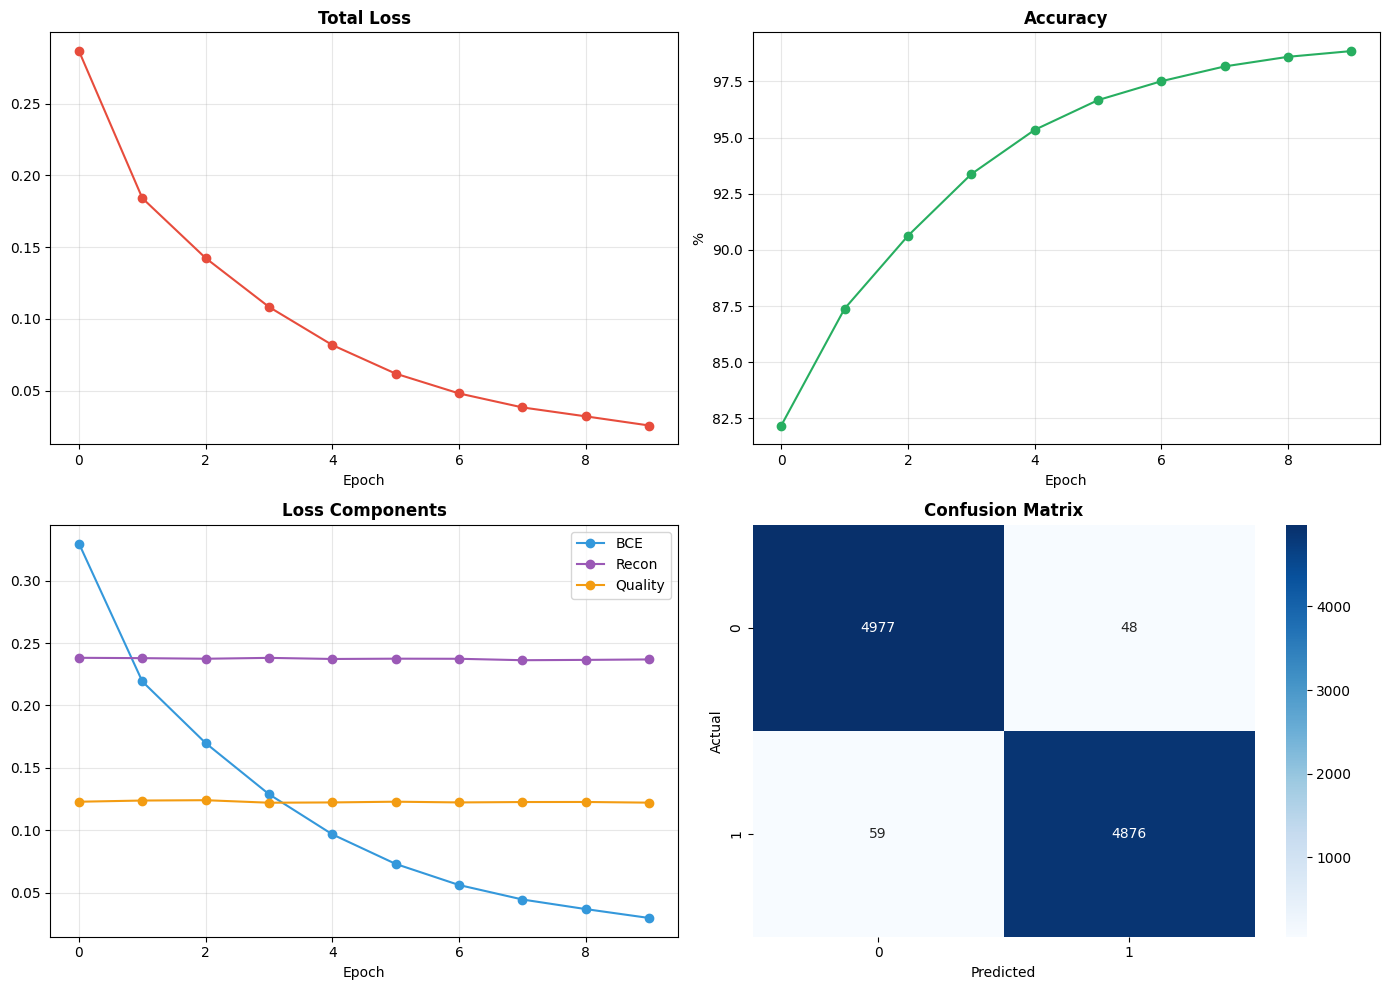


✅ All done! Results saved to: /content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined_weighted_bce


In [ ]:
# ============================================================================
# SECTION 13: VISUALIZATIONS
# ============================================================================
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].plot(history['train_total_loss'], marker='o', color='#e74c3c')
axes[0, 0].set_title('Total Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_accuracy'], marker='o', color='#27ae60')
axes[0, 1].set_title('Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('%')
axes[0, 1].grid(True, alpha=0.3)

# Loss components
axes[1, 0].plot(history['train_bce_loss'], marker='o', label='BCE', color='#3498db')
axes[1, 0].plot(history['train_recon_loss'], marker='o', label='Recon', color='#9b59b6')
axes[1, 0].plot(history['train_quality_loss'], marker='o', label='Quality', color='#f39c12')
axes[1, 0].set_title('Loss Components', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix', fontweight='bold')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout()
#plt.savefig(os.path.join(CONFIG['save_dir'], 'training_results.png'), dpi=150)
plt.savefig(os.path.join(CONFIG['save_dir'], 'training_results_weighted_bce.png'), dpi=150)
plt.show()

print(f"\n✅ All done! Results saved to: {CONFIG['save_dir']}")

----

# Saving as .pth

In [ ]:
# Load checkpoint
checkpoint = torch.load(os.path.join(CONFIG['save_dir'], 'final_combined_model_weighted_bce.pt'))

# Recreate models
cnn = SimpleCNN(input_channels=3, num_classes=2).to(device)
vae = VAE(in_channels=3, hidden_channels=[32,64,128], out_channels=256, height=64, width=64, latent_dim=128).to(device)

# Load weights
cnn.load_state_dict(checkpoint['cnn_state_dict'])
vae.load_state_dict(checkpoint['vae_state_dict'])

# Save full models
torch.save(cnn, os.path.join(CONFIG['save_dir'], 'cnn_full_model.pth'))
torch.save(vae, os.path.join(CONFIG['save_dir'], 'vae_full_model.pth'))
print("Full models saved!")

Full models saved!


----